In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow-addons
!pip install toolz scikit-allel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 10.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.12.0


## Setup

In [4]:
import os
# os.environ["MODIN_CPUS"] = "8"
# from distributed import Client
# client = Client()
import numpy as np
import math
import re
import itertools
import random
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_addons as tfa
from sklearn import metrics
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import constraints
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras.applications import efficientnet as efn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from tensorflow.keras.constraints import Constraint
# import allel
from scipy.spatial.distance import squareform
%matplotlib inline
from toolz import interleave
from tqdm import tqdm
import allel
from scipy.spatial.distance import squareform
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV, ElasticNetCV
from sklearn.model_selection import KFold,StratifiedKFold

print("Tensorflow version " + tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Tensorflow version 2.12.0


## Hardware Config

In [5]:
# Detect hardware, return appropriate distribution strategy
try:
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', TPU.master())
except ValueError:
    print('Running on GPU')
    TPU = None

if TPU:
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.TPUStrategy(TPU)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

N_REPLICAS = strategy.num_replicas_in_sync
# Number of computing cores, is 8 for a TPU V3-8
print(f'N_REPLICAS: {N_REPLICAS}')

Running on TPU  grpc://10.9.10.138:8470
N_REPLICAS: 8


## Prepare the data

In [6]:
root_dir = '[data_dir]/'
new_data_header = ""
# get header
with open(root_dir + "ALL.chr22.mergedSV.v8.20130502.svs.genotypes.vcf", 'r') as f_in:
    # skip info
    for line_num in range(70):
        f_in.readline()

    new_data_header = f_in.readline()
# load data

# load genotype
genotypes = pd.read_csv(root_dir + "ALL.chr22.mergedSV.v8.20130502.svs.genotypes.vcf", comment='#', sep='\t', names=new_data_header.strip().split('\t'), header=None)#.iloc[:, 9:]



In [7]:
geno_headers = genotypes.POS.values
positions = [int(h) for h in geno_headers]
positions[:2]

[16050654, 16533236]

In [8]:
def find_snv_chunk(s):
  s_split = s.split(";")
  for ss in s_split:
    if ss.startswith("SVTYPE"):
      return ss
  return ""


In [9]:
info = genotypes.iloc[:, 7:8]
snv_types = info.applymap(lambda x: find_snv_chunk(x).split("=")[-1]).values.flatten()
np.unique(snv_types, return_counts=True)

(array(['ALU', 'CNV', 'DEL', 'DEL_ALU', 'DUP', 'INS', 'INV', 'LINE1',
        'SVA'], dtype=object),
 array([ 96,  55, 573,   9,  79,   4,   5,   7,  20]))

In [10]:
genotypes = genotypes.iloc[:, 9:].T
headers = genotypes.columns[:]
genotypes

,0,1,2,3,4,5,6,7,8,9,...,838,839,840,841,842,843,844,845,846,847
HG00096,3|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00097,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00099,0|0,0|0,0|0,0|0,0|0,0|1,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00100,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
HG00101,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NA21137,3|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21141,3|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21142,0|0,0|0,0|0,0|0,0|0,0|0,0|1,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0
NA21143,0|0,0|0,0|0,0|0,0|0,0|0,1|0,0|0,0|0,0|0,...,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0,0|0


In [11]:
ped_file = '[data_dir]/integrated_call_samples.20130502.ALL.ped'
pedigree = pd.read_csv(ped_file, sep='\t', index_col='Individual ID')

In [12]:
pedigree.head()

,Family ID,Paternal ID,Maternal ID,Gender,Phenotype,Population,Relationship,Siblings,Second Order,Third Order,Children,Other Comments
Individual ID,,,,,,,,,,,,
HG00096,HG00096,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00097,HG00097,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00098,HG00098,0,0,1,0,GBR,unrel,0,0,0,0,0
HG00099,HG00099,0,0,2,0,GBR,unrel,0,0,0,0,0
HG00100,HG00100,0,0,2,0,GBR,unrel,0,0,0,0,0


In [13]:
Y_train = pedigree.loc[genotypes.index]['Population']
Y_train.shape

(2504,)

In [14]:
X = genotypes[genotypes.index.isin(Y_train.index)]
X.shape

(2504, 848)

In [15]:
def get_max_genotype(g):
  v1, v2 = g.split("|")
  return max(int(v1), int(v2)) + 1

def key_gen(v1, v2):
  return f"{v1}|{v2}"

In [16]:
genotype_keys = np.unique(X.values)
max_gen = max(map(get_max_genotype, genotype_keys))
onehot_encoding_depth = max_gen**2 + 1
MISSING_VALUE = [0 for _ in range(max_gen+1)]
MISSING_VALUE[-1] = 1
genotype_keys = [key_gen(i,j) for i in range(max_gen) for j in range(max_gen)]
replacement_dict = {k:i for i,k in enumerate(genotype_keys)}
reverse_replacement_dict = {v:k for k,v in replacement_dict.items()}
max_gen, onehot_encoding_depth, MISSING_VALUE
# replacement_dict

(6, 37, [0, 0, 0, 0, 0, 0, 1])

In [17]:
X = X.replace(replacement_dict)
X.shape

(2504, 848)

### MAF


In [36]:
info

,INFO
0,"AC=9,87,599,20;AF=0.00179712,0.0173722,0.11960..."
1,AC=125;AF=0.0249601;AFR_AF=0.09;AMR_AF=0.0086;...
2,AC=29;AF=0.00579073;AFR_AF=0.0098;AMR_AF=0.001...
3,AC=186;AF=0.0371406;AFR_AF=0.1021;AMR_AF=0.014...
4,AC=2;AF=0.00039936;AFR_AF=0;AMR_AF=0;AN=5008;C...
...,...
843,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...
844,"AC=6,47;AF=0.00119808,0.00938498;AFR_AF=0.0023..."
845,AC=3;AF=0.00059904;AFR_AF=0.0023;AMR_AF=0;AN=5...
846,AC=1;AF=0.00019968;AFR_AF=0;AMR_AF=0;AN=5008;C...


In [18]:
def maf_mapper(txt):
  af = min(list(map(lambda x: float(x), txt.split(";")[1].split("=")[1].split(","))))
  return min(af, 1-af)

In [37]:
mafs = info.applymap(maf_mapper)
mafs

,INFO
0,0.001797
1,0.024960
2,0.005791
3,0.037141
4,0.000399
...,...
843,0.000200
844,0.001198
845,0.000599
846,0.000200


In [38]:
max(mafs.values)

array([0.496605])

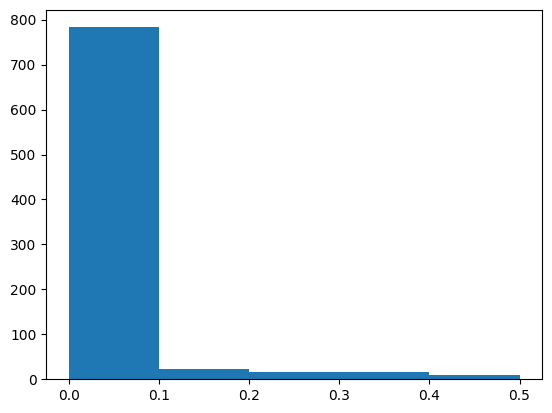

In [39]:
plt.hist(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5]);

In [40]:
bin_labels = np.digitize(mafs, bins=[0, 0.1, 0.2, 0.3, 0.4, 0.5], right=False)
bin_general_labels, bin_counts = np.unique(bin_labels, return_counts=True)
bin_general_labels, bin_counts

(array([1, 2, 3, 4, 5]), array([783,  22,  17,  16,  10]))

In [23]:
# hyperparameters
feature_size = X.shape[1]
inChannel = max_gen + 1
learning_rate = 0.001
weight_decay = 0.00001
regularization_coef_l1 = 1e-5
dropout_rate = 0.25

## Convert to tensorflow dataset

In [24]:
@tf.function()
def add_attention_mask(X_sample, y_sample):
  depth = max_gen + 1
  mask_size = tf.cast(X_sample.shape[0]*0.5, dtype=tf.int64)
  mask_idx = tf.reshape(tf.random.shuffle(tf.range(X_sample.shape[0]))[:mask_size], (-1, 1))
  updates = tf.math.add(tf.zeros(shape=(mask_idx.shape[0]), dtype=tf.int64), max_gen)
  X_masked = tf.tensor_scatter_nd_update(X_sample, mask_idx, updates)
  return tf.one_hot(X_masked, depth), tf.one_hot(y_sample, depth-1)

In [26]:
def map_values_1(x):
  return int(reverse_replacement_dict[x].split('|')[0])

def map_values_2(x):
  return int(reverse_replacement_dict[x].split('|')[1])

def get_dataset(x, chunk_start, chunk_end, start_offset, end_offset, batch_size, training=True):
  AUTO = tf.data.AUTOTUNE

  _x = np.empty((x.shape[0] * 2, chunk_end-chunk_start), dtype=x.dtype)

  map_values_1_vec = np.vectorize(map_values_1)
  map_values_2_vec = np.vectorize(map_values_2)

  _x[0::2] = map_values_1_vec(x[:, chunk_start:chunk_end])
  _x[1::2] = map_values_2_vec(x[:, chunk_start:chunk_end])
  new_chunk_end = _x.shape[1]

  dataset = tf.data.Dataset.from_tensor_slices((_x,
                                                _x[:, start_offset:new_chunk_end-end_offset]))

  if training:
    dataset = dataset.shuffle(_x.shape[0], reshuffle_each_iteration=True)
    dataset = dataset.repeat()

  # Add Attention Mask
  dataset = dataset.map(add_attention_mask, num_parallel_calls=AUTO, deterministic=False)

  # Prefetech to not map the whole dataset
  dataset = dataset.prefetch(AUTO)

  dataset = dataset.batch(batch_size, drop_remainder=True, num_parallel_calls=AUTO)

  return dataset

## Model

In [52]:
kr = 1e-6
drop_prec = 0.3

In [53]:
def createSCDA(base_size=128, kernel_size=32):
  inputt = layers.Input(shape=(feature_size, inChannel))
  # encoder
  x = layers.Conv1D(base_size, kernel_size, padding='same',activation='relu',
                        kernel_regularizer=regularizers.l1(kr),
                        input_shape=(feature_size, inChannel))(inputt)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(drop_prec)(x)
  x = layers.Conv1D(base_size*2, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)
  x = layers.BatchNormalization()(x)
  x = layers.MaxPool1D(2)(x)
  x = layers.Dropout(drop_prec)(x)

  # bridge
  x = layers.Conv1D(base_size*4, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)

  # decoder
  x = layers.Conv1D(base_size*2, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)
  x = layers.BatchNormalization()(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.Dropout(drop_prec)(x)

  x = layers.Conv1D(base_size, kernel_size, padding='same', activation='relu',
                        kernel_regularizer=regularizers.l1(kr)
                        )(x)
  x = layers.BatchNormalization()(x)
  x = layers.UpSampling1D(2)(x)
  x = layers.Dropout(drop_prec)(x)

  x = layers.Conv1D(inChannel-1, kernel_size, activation='softmax', padding='same')(x)
  #   x = layers.Dense(inChannel-1, activation=tf.nn.softmax)(x)

  SCDA = tf.keras.models.Model(inputt, x)

  return SCDA

In [54]:
model = createSCDA()
model.build((1, feature_size, inChannel))
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 848, 7)]          0         
                                                                 
 conv1d_6 (Conv1D)           (None, 848, 128)          28800     
                                                                 
 batch_normalization_4 (Batc  (None, 848, 128)         512       
 hNormalization)                                                 
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 424, 128)         0         
 1D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 424, 128)          0         
                                                                 
 conv1d_7 (Conv1D)           (None, 424, 256)          1048

In [55]:
def create_model():
  model =  createSCDA()
  optimizer = tfa.optimizers.LAMB(learning_rate=learning_rate)
  model.compile(optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=tf.keras.metrics.CategoricalAccuracy())
  return model

In [56]:
METRIC = "val_loss"

def create_callbacks(kfold=0, metric = METRIC):


    reducelr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor= metric,
        mode='auto',
        factor=0.5,
        patience=5,
        verbose=0
    )

    earlystop = tf.keras.callbacks.EarlyStopping(
        monitor= metric,
        mode='auto',
        patience= 20,
        verbose=1,
        restore_best_weights=True
    )

    callbacks = [
                #  checkpoint,
                 reducelr,
                 earlystop]

    return callbacks

In [57]:
np.unique(Y_train.values)

array(['ACB', 'ASW', 'BEB', 'CDX', 'CEU', 'CHB', 'CHS', 'CLM', 'ESN',
       'FIN', 'GBR', 'GIH', 'GWD', 'IBS', 'ITU', 'JPT', 'KHV', 'LWK',
       'MSL', 'MXL', 'PEL', 'PJL', 'PUR', 'STU', 'TSI', 'YRI'],
      dtype=object)

## Training

In [58]:
save_dir = "[save_dir]/"

if not os.path.exists(save_dir):
  # shutil.rmtree(save_dir)
  os.makedirs(save_dir)

In [59]:
# A TPU V3-8 has 8 computing cores, the global batch size will be 1/16 x 8 = 8/128
BATCH_SIZE_BASE = 2
# Training configuration
BATCH_SIZE = BATCH_SIZE_BASE * N_REPLICAS if TPU else 5
BATCH_SIZE

16

In [60]:
# With constraint
N_SPLITS=3
NUM_EPOCHS = 1000
accuracies = []
results = None
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=2022)
fold = 0
_x = X[X.index.isin(Y_train.index)].to_numpy()
_y = Y_train.to_numpy()
for train_index, test_index in kf.split(_x):
  fold += 1

  print(f"Training using fold {fold}")
  x_train, y_train, test_dataset, test_indices = _x[train_index], _y[train_index], (_x[test_index], _y[test_index]),Y_train.index[test_index]
  x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.10,
                                      random_state=fold,
                                      shuffle=True)

  steps_per_epoch = 2*x_train.shape[0]//BATCH_SIZE
  validation_steps = 2*x_valid.shape[0]//BATCH_SIZE
  train_dataset = get_dataset(x_train, 0, feature_size, 0, 0, BATCH_SIZE)
  valid_dataset = get_dataset(x_valid, 0, feature_size, 0, 0, BATCH_SIZE, training=False)

  K.clear_session()
  callbacks = create_callbacks()
  with strategy.scope():
    model = create_model()
    history = model.fit(train_dataset, steps_per_epoch=steps_per_epoch, epochs=NUM_EPOCHS,
            validation_data=valid_dataset,
            validation_steps=validation_steps,
            callbacks=callbacks, verbose=1)
  for missing_perc in [
                        0.05,
                        0.1,
                        0.2
                         ]:
    save_name = save_dir + f"preds_mixed_mr_{missing_perc}_fold_{fold}_probs"
    avg_accuracy = []
    preds = []
    true_labels = []

    # to_save_array = np.zeros((test_dataset[0].shape[0], test_dataset[0].shape[1]), dtype=object)
    test_X_missing = np.empty((test_dataset[0].shape[0] * 2, test_dataset[0].shape[1]), dtype=test_dataset[0].dtype)
    map_values_1_vec = np.vectorize(map_values_1)
    map_values_2_vec = np.vectorize(map_values_2)
    test_X_missing[0::2] = map_values_1_vec(test_dataset[0])
    test_X_missing[1::2] = map_values_2_vec(test_dataset[0])
    test_X_missing = to_categorical(test_X_missing, inChannel)

    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      test_X_missing[i*2:i*2+2, missing_index, :] = MISSING_VALUE
      # predict
    predict_onehots = model.predict(test_X_missing, verbose=0)
    to_save_array = np.copy(predict_onehots)
    for i in tqdm(range(test_dataset[0].shape[0])):
      missing_index, _ = train_test_split(np.arange(x_train.shape[1]), train_size=missing_perc,
                                    random_state=i + fold,
                                    shuffle=True,
                                    stratify=bin_labels
                                    )
      # only care the missing position
      predict_missing_onehot = predict_onehots[i*2:(i+1)*2, missing_index, :]
      # predict label
      predict_missing = np.argmax(predict_missing_onehot, axis=2)
      predict_missing_final = np.zeros((1, predict_missing.shape[1]))
      for j in range(predict_missing.shape[1]):
        predict_missing_final[:, j] = replacement_dict['|'.join([str(o) for o in predict_missing[:, j].tolist()])]
      preds.extend(predict_missing_final.ravel().tolist())

      predict_haplotypes = np.argmax(predict_onehots[i*2:(i+1)*2,], axis=2)
      # for j in range(predict_onehots.shape[1]):
      #   to_save_array[i, j] = '|'.join([str(o) for o in predict_haplotypes[:, j].tolist()])
      # real label
      label_missing_onehot = test_dataset[0][i:i + 1, missing_index]
      # label_missing = np.argmax(label_missing_onehot, axis=2)
      label_missing = test_dataset[0][i:i + 1, missing_index]
      true_labels.extend(label_missing.ravel().tolist())
      # accuracy
      correct_prediction = np.equal(predict_missing_final, label_missing)
      accuracy = np.mean(correct_prediction)

      avg_accuracy.append(accuracy)

    # df = pd.DataFrame(to_save_array, columns= headers[:], index = Y_train.index[test_index])
    # df.to_csv(save_name)
    np.save(save_name, to_save_array)
    print('The average imputation accuracy ' \
          'on test data with {} missing genotypes is {:.4f}: '
        .format(missing_perc, np.mean(avg_accuracy)))
    cnf_matrix = confusion_matrix(true_labels, preds)
    FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)
    FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
    TP = np.diag(cnf_matrix)
    TN = cnf_matrix.sum() - (FP + FN + TP)
    FP = FP.astype(float)
    FN = FN.astype(float)
    TP = TP.astype(float)
    TN = TN.astype(float)
    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    # Specificity or true negative rate
    TNR = TN/(TN+FP)
    print(f"Sensitivity: {np.mean(TPR)}")
    print(f"Specificity: {np.mean(TNR)}")
    print(f"F1-score macro: {f1_score(true_labels, preds, average='macro')}")
    print(f"F1-score micro: {f1_score(true_labels, preds, average='micro')}")
    accuracies.append(np.mean(avg_accuracy))
  print(f"=====================================")



Training using fold 1
Epoch 1/1000
187/187 [==============================] - 39s 62ms/step - loss: 1.6048 - categorical_accuracy: 0.6217 - val_loss: 3.4614 - val_categorical_accuracy: 0.0743 - lr: 0.0010
Epoch 2/1000
187/187 [==============================] - 5s 28ms/step - loss: 0.5256 - categorical_accuracy: 0.9557 - val_loss: 26.0633 - val_categorical_accuracy: 0.0181 - lr: 0.0010
Epoch 3/1000
187/187 [==============================] - 6s 31ms/step - loss: 0.2330 - categorical_accuracy: 0.9730 - val_loss: 25.6727 - val_categorical_accuracy: 0.0535 - lr: 0.0010
Epoch 4/1000
187/187 [==============================] - 5s 28ms/step - loss: 0.1727 - categorical_accuracy: 0.9804 - val_loss: 5.1302 - val_categorical_accuracy: 0.1605 - lr: 0.0010
Epoch 5/1000
187/187 [==============================] - 6s 31ms/step - loss: 0.1566 - categorical_accuracy: 0.9824 - val_loss: 1.0637 - val_categorical_accuracy: 0.6340 - lr: 0.0010
Epoch 6/1000
187/187 [==============================] - 6s 30ms/s

100%|██████████| 835/835 [00:05<00:00, 150.11it/s]


The average imputation accuracy on test data with 0.05 missing genotypes is 0.9567: 
Sensitivity: nan
Specificity: 0.9561796818016162
F1-score macro: 0.20197411439512575


<ipython-input-60-db5e2b5abfb3>:105: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)


F1-score micro: 0.9567436555460507


100%|██████████| 835/835 [00:04<00:00, 175.67it/s]


The average imputation accuracy on test data with 0.1 missing genotypes is 0.9510: 
Sensitivity: 0.1989929825653931
Specificity: 0.9630854857576057
F1-score macro: 0.23872904625201882
F1-score micro: 0.9510407755916738


100%|██████████| 835/835 [00:04<00:00, 170.17it/s]


The average imputation accuracy on test data with 0.2 missing genotypes is 0.9546: 
Sensitivity: 0.14890542443063212
Specificity: 0.9670244344363785
F1-score macro: 0.18270758040546303
F1-score micro: 0.9546114870850015
Training using fold 2
Epoch 1/1000
187/187 [==============================] - 18s 34ms/step - loss: 1.5610 - categorical_accuracy: 0.6457 - val_loss: 6.7112 - val_categorical_accuracy: 0.0219 - lr: 0.0010
Epoch 2/1000
187/187 [==============================] - 6s 35ms/step - loss: 0.4836 - categorical_accuracy: 0.9574 - val_loss: 25.6029 - val_categorical_accuracy: 0.0212 - lr: 0.0010
Epoch 3/1000
187/187 [==============================] - 5s 29ms/step - loss: 0.2228 - categorical_accuracy: 0.9733 - val_loss: 23.3839 - val_categorical_accuracy: 0.0629 - lr: 0.0010
Epoch 4/1000
187/187 [==============================] - 6s 30ms/step - loss: 0.1748 - categorical_accuracy: 0.9792 - val_loss: 8.8077 - val_categorical_accuracy: 0.1390 - lr: 0.0010
Epoch 5/1000
187/187 [=====

100%|██████████| 835/835 [00:06<00:00, 129.39it/s]


The average imputation accuracy on test data with 0.05 missing genotypes is 0.9569: 
Sensitivity: nan
Specificity: 0.9529422138731096
F1-score macro: 0.22673532004147426


<ipython-input-60-db5e2b5abfb3>:105: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)


F1-score micro: 0.9568862275449102


100%|██████████| 835/835 [00:05<00:00, 151.10it/s]


The average imputation accuracy on test data with 0.1 missing genotypes is 0.9516: 
Sensitivity: nan
Specificity: 0.9592792788219872


<ipython-input-60-db5e2b5abfb3>:105: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)


F1-score macro: 0.19568831083614624
F1-score micro: 0.9516110635871114


100%|██████████| 835/835 [00:04<00:00, 169.50it/s]


The average imputation accuracy on test data with 0.2 missing genotypes is 0.9553: 
Sensitivity: 0.15798180424414712
Specificity: 0.9572812412683852
F1-score macro: 0.18949647182084442
F1-score micro: 0.9553201289728236
Training using fold 3
Epoch 1/1000
187/187 [==============================] - 17s 37ms/step - loss: 1.6193 - categorical_accuracy: 0.6158 - val_loss: 4.6686 - val_categorical_accuracy: 0.0644 - lr: 0.0010
Epoch 2/1000
187/187 [==============================] - 5s 28ms/step - loss: 0.5131 - categorical_accuracy: 0.9556 - val_loss: 30.0980 - val_categorical_accuracy: 0.0109 - lr: 0.0010
Epoch 3/1000
187/187 [==============================] - 5s 29ms/step - loss: 0.2285 - categorical_accuracy: 0.9731 - val_loss: 26.9137 - val_categorical_accuracy: 0.0477 - lr: 0.0010
Epoch 4/1000
187/187 [==============================] - 6s 30ms/step - loss: 0.1750 - categorical_accuracy: 0.9795 - val_loss: 6.6350 - val_categorical_accuracy: 0.1380 - lr: 0.0010
Epoch 5/1000
187/187 [=====

100%|██████████| 834/834 [00:07<00:00, 115.17it/s]


The average imputation accuracy on test data with 0.05 missing genotypes is 0.9583: 
Sensitivity: 0.22954294637757208
Specificity: 0.9307819036174614
F1-score macro: 0.2875822214979154
F1-score micro: 0.9582619618590842


100%|██████████| 834/834 [00:07<00:00, 118.11it/s]


The average imputation accuracy on test data with 0.1 missing genotypes is 0.9516: 
Sensitivity: 0.22829613938607562
Specificity: 0.9382610188147386
F1-score macro: 0.27234121943255335
F1-score micro: 0.9515815918693616


100%|██████████| 834/834 [00:07<00:00, 105.14it/s]


The average imputation accuracy on test data with 0.2 missing genotypes is 0.9549: 
Sensitivity: nan
Specificity: 0.9606870559400602


<ipython-input-60-db5e2b5abfb3>:105: RuntimeWarning: invalid value encountered in divide
  TPR = TP/(TP+FN)


F1-score macro: 0.17841979811757017
F1-score micro: 0.9549472847757298


In [61]:
from google.colab import runtime
runtime.unassign()